* **Student**: Minhchau Dang
* **Email Address**: minhchau.dang@berkeley.edu
* **Course**: 2016-0111 DATASCI W261: Machine Learning at Scale
* **Section**: Spring 2016, Section 2
* **Assignment**: Homework 9, Week 9
* **Submission Date**: March 19, 2016

In [ ]:
%%javascript
require(['base/js/utils'], function(utils) {
    utils.load_extensions('usability/ruler/main');
    utils.load_extensions('usability/toc2/main');
    utils.load_extensions('usability/toggle_all_line_numbers/main');
    utils.load_extensions('autosaveclasses');
});

<IPython.core.display.Javascript object>

# Specify Hadoop Settings

In [ ]:
hdfs_base_folder = '/user/ubuntu'
mapper_count = 32
reducer_count = 32

# Code Legibility Utilities

## Data acquisition utilities

### File management utilities

Different runner types have keep their files in different locations. These utility methods allow us to get some uniformity in the scripts since it will return the actual paths needed by different runner types.

In [ ]:
import os
import subprocess

"""
Returns whether the given file path corresponds to something on the file system used by
the given runner.
"""
def file_exists(runner_type, name):
    if runner_type in ['inline', 'local']:
        return os.path.isfile(name)

    status = subprocess.call([
        'hdfs', 'dfs', '-test', '-f', hdfs_base_folder + '/' + name
    ])

    return status == 0

"""
Returns whether the given file path corresponds to something on the file system used by
the given runner.
"""
def folder_exists(runner_type, name):
    if runner_type in ['inline', 'local']:
        return os.path.isdir(name)

    status = subprocess.call([
        'hdfs', 'dfs', '-test', '-d', hdfs_base_folder + '/' + name
    ])

    return status == 0

"""
Removes the folder located at the given path. Note that it does a recursive remove, so it
doesn't throw an error if it's a file (it will still delete it).
"""
def remove_folder(runner_type, folder_name):
    if runner_type in ['inline', 'local']:
        !rm -rf $folder_name
    else:
        !hdfs dfs -rm -r -f -skipTrash $hdfs_base_folder/$folder_name

"""
Returns an appropriate file path to pass to a runner as an input/output folder.
"""
def get_mrjob_path(runner_type, folder_name):
    if folder_name is None or folder_name == '':
        return ''

    if runner_type in ['inline', 'local']:
        return folder_name

    return 'hdfs://' + hdfs_base_folder + '/' + folder_name

### File download utilities

Since the URLs for the files tend to be very long, first we create some utility methods which make it more clear what we're doing when we're downloading data from either Dropbox or Amazon S3.

In [ ]:
"""
Utility method to split the file to make sure that multiple mapper tasks (and hopefully
multiple reducer tasks) get created for our jobs in Hadoop.
"""
def split_for_hdfs(file_name, target_folder = None):
    if target_folder is None:
        target_folder = file_name

    if folder_exists('hadoop', target_folder):
        return

    !mkdir -p /run/shm/$target_folder
    !split $file_name -l 100000 /run/shm/$target_folder/

    !hdfs dfs -mkdir -p $target_folder
    !hdfs dfs -copyFromLocal /run/shm/$target_folder/* $hdfs_base_folder/$target_folder

    !rm -rf /run/shm/$target_folder

"""
Utility method which downloads a Dropbox file from the folder for this assignment.
"""
def get_dropbox_file(dropbox_folder_name, folder_name, file_name):
    !mkdir -p input/$folder_name
    target_file_path = 'input/%s/%s' % (folder_name, file_name)

    if os.path.isfile(target_file_path):
        return target_file_path

    dropbox_url = 'https://www.dropbox.com/sh'
    !curl -Ls $dropbox_url/$dropbox_folder_name/$file_name > $target_file_path

    return target_file_path

"""
Utility method which downloads a file from an S3 bucket for this assignment.
"""
def get_s3_file(folder_name, file_name):
    !mkdir -p input/$folder_name
    target_file_path = 'input/%s/%s' % (folder_name, file_name)

    if os.path.isfile(target_file_path):
        return target_file_path

    !aws s3 --region us-west-2 cp \
        s3://ucb-mids-mls-networks/$folder_name/$file_name \
        $target_file_path

    return target_file_path

### Content retrieval utilities

We also sometimes need to `grep` a file or `wc -l` the output. The following functions allow us to do so in a runner-agnostic way within the code itself by handling the runner-specific logic here.

In [ ]:
"""
Pipes the standard output for the cat command to the given command and returns the result.
"""
def pipe_cat_output(runner_type, path, command = 'cat'):
    if file_exists(runner_type, path):
        cat_path = path
    elif folder_exists(runner_type, path):
        cat_path = path + '/*'
    else:
        return None

    if runner_type in ['inline', 'local']:
        result = !cat $cat_path | $command
    else:
        result = !hdfs dfs -cat $hdfs_base_folder/$cat_path | $command

    return '\n'.join(result)

"""
Returns the total number of lines in all files contained in the specified folder.
"""
def get_line_count(runner_type, folder_name):
    return int(pipe_cat_output(runner_type, folder_name, 'wc -l'))

"""
Returns the lines in the specified folder starting with the specified key. This can be
parsed by the runner to yield the original key and value.
"""
def get_lines_with_key(runner_type, folder_name, key):
    return pipe_cat_output(runner_type, folder_name, 'grep "^' + key + '"')

## Dangling node identification utilities

Some of the PageRank tasks in the homework require that have the dangling nodes included as input when processing the graph, but they are often missing. The following jobs perform a join between the in-degree node table and the out-degree node table to allow us to fix that.

### Create MRJob to tag tables for join

First, we need to tag the different tables so that as we process the input, we know what table we are interacting with.

In [ ]:
from mrjob.job import MRJob
from mrjob.protocol import ReprProtocol
from mrjob.step import MRStep
import sys

class TagWithTableNameJob(MRJob):

    OUTPUT_PROTOCOL = ReprProtocol

    def configure_options(self):
        super(TagWithTableNameJob, self).configure_options()
        self.add_passthrough_option('--mapper-count', default=1)
        self.add_passthrough_option('--table-name')

    """
    Add the table name as part of the value.
    """
    def mapper(self, _, line):
        name, value = line.split('\t', 1)
        yield name, (self.options.table_name, eval(value))

    """
    Set the mapper count options to make sure that MRJob creates enough mapper tasks.
    """
    def steps(self):
        step = MRStep(
            mapper = self.mapper,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count
            })

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = TagWithTableNameJob()
    job.run()

Add a utility function to make it easy to call.

In [ ]:
def tag_with_table_name_job(runner_type, graph_file, table_name):
    if graph_file is None:
        return None

    table_file = graph_file + '.table'

    remove_folder(runner_type, table_file)

    mrjob_graph_file = get_mrjob_path(runner_type, graph_file)
    mrjob_table_file = get_mrjob_path(runner_type, table_file)

    !python TagWithTableNameJob.py \
        -r $runner_type \
        --strict-protocols \
        --no-bootstrap-mrjob \
        --no-output \
        --table-name $table_name \
        --output-dir $mrjob_table_file \
        --mapper-count $mapper_count \
        $mrjob_graph_file \
        2> /dev/null

    return table_file

### Create MRJob to add dangling nodes

Dangling node identification is effectively a full outer join in the sense that we will emit the key as long as it appears in either table, but we only emit the values from the left table (we drop any values from the right table).

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import ReprProtocol
import sys

class AddDanglingNodesJob(MRJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    def configure_options(self):
        super(AddDanglingNodesJob, self).configure_options()
        self.add_passthrough_option('--left-table')
        self.add_passthrough_option('--right-table')

        self.add_passthrough_option('--mapper-count', type='int', default=1)
        self.add_passthrough_option('--reducer-count', type='int', default=1)

    """
    If you are joining with yourself, that means we didn't have a file which gives you
    degrees for the other table. In this case, we will emit our neighbors in order to
    effectively derive the other table.
    """
    def mapper_init(self):
        self.derive_right_table = self.options.left_table == self.options.right_table

    """
    We are only interested in generating what the left table will be. Therefore, we will
    emit the full entries of the left table, but only an empty value for the right table.
    """
    def mapper(self, name, table_row):
        table_name, neighbors = table_row

        if self.options.left_table == table_name:
            yield name, neighbors
        else:
            yield name, {}

        # If we have to derive the right table, we'll emit each of our neighbors.

        if self.derive_right_table:
            for neighbor_name, degree in neighbors.iteritems():
                yield neighbor_name, {}

    """
    Emit the left table row if found, and emit the blank entry if only right table entries
    were found (dangling node).
    """
    def reducer(self, name, all_neighbors):
        emit_neighbors = {}

        for neighbors in all_neighbors:
            if len(neighbors) != 0:
                emit_neighbors = neighbors

        yield name, emit_neighbors

    """
    Configure the reducer as a combiner and set the mapper and reducer count options to
    make sure that MRJob creates enough mapper/reducer tasks.
    """
    def steps(self):
        step = MRStep(
            mapper_init = self.mapper_init, mapper = self.mapper,
            combiner = self.reducer, reducer = self.reducer,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count,
                'mapreduce.job.reduces': self.options.reducer_count
            })

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = AddDanglingNodesJob()
    job.run()

Add a utility function to make it easy to call.

In [ ]:
def add_dangling_nodes_job(runner_type, out_nodes_graph, in_nodes_graph):

    # Tag the tables so that we can perform the join

    if out_nodes_graph is None:
        print 'Failed to create a tagged graph for', out_nodes_graph
        return

    out_nodes_table = tag_with_table_name_job(runner_type, out_nodes_graph, 'out')

    if out_nodes_table is None:
        print 'Failed to create a tagged graph for', out_nodes_graph
        return

    in_nodes_table = tag_with_table_name_job(runner_type, in_nodes_graph, 'in')

    if in_nodes_table is None and in_nodes_graph is not None:
        print 'Failed to create a tagged graph for', in_nodes_graph
        return

    # If we are missing one of the tables, we'll join the table with itself

    left_table = 'out'
    right_table = 'in'

    if in_nodes_graph is None:
        right_table = 'out'
        in_nodes_table = ''

    # Now we run the job with all the tables we've created

    new_nodes_graph = out_nodes_graph + '.all'
    remove_folder(runner_type, new_nodes_graph)

    mrjob_out_nodes_table = get_mrjob_path(runner_type, out_nodes_table)
    mrjob_in_nodes_table = get_mrjob_path(runner_type, in_nodes_table)
    mrjob_new_nodes_graph = get_mrjob_path(runner_type, new_nodes_graph)

    !python AddDanglingNodesJob.py \
        -r $runner_type \
        --strict-protocols \
        --no-bootstrap-mrjob \
        --no-output \
        --left-table $left_table \
        --right-table $right_table \
        --mapper-count $mapper_count \
        --reducer-count $reducer_count \
        --output-dir $mrjob_new_nodes_graph \
        $mrjob_out_nodes_table $mrjob_in_nodes_table \
        2> /dev/null

    return new_nodes_graph

# HW 9.0: Short answer questions

## HW 9.0a

> What is PageRank and what is it used for in the context of web search?

## HW 9.0b

> What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to
compute the steady stade distibuton?

## HW 9.0c

> OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)

# HW 9.1: MRJob implementation of basic PageRank

## Create PageRank MRJob

> Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).

> Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network),
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).

> [NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability $d$,
one of the hyperlinks in the current page. This probability is represented by a so-called
'damping factor' $d$, where $d \in (0, 1)$. Otherwise, with probability $(1 − d)$, the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and "teleports" to that page]

### Implement PageRank algorithm

First, we want a job that will perform a single iteration of the page rank computation where it will determine the updated page rank based on the rank contribution from all incoming nodes and from random teleport. We also include the known dangling mass from the previous iteration of the algorithm (or, the uniform number of dangling nodes.

In [ ]:
from __future__ import division
from mrjob.job import MRJob
from mrjob.protocol import ReprProtocol
from mrjob.step import MRStep
import sys

class PageRankSingleIterationJob(MRJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    def configure_options(self):
        super(PageRankSingleIterationJob, self).configure_options()
        self.add_passthrough_option('--node-count', type='int')
        self.add_passthrough_option('--damping-factor', type='float', default=0.85)
        self.add_passthrough_option('--dangling-mass', type='float', default=0.0)

        self.add_passthrough_option('--mapper-count', type='int', default=1)
        self.add_passthrough_option('--reducer-count', type='int', default=1)

    """
    Distribute the mass to your neighbors, making sure to emit your own information so
    that is available in the next iteration.
    """
    def mapper(self, key, node_data):

        # Handle initial state where you only have a dictionary. Give everyone a uniform
        # probability in this case.

        if isinstance(node_data, dict):
            old_page_rank = 1.0 / self.options.node_count
            older_page_rank = 0.0
            neighbors = node_data
        else:
            old_page_rank, older_page_rank, neighbors = node_data

        # Emit yourself with a page rank contribution of zero, but with your neighbors
        # and your old page rank. This allows information to persist between iterations.

        yield key, (0.0, old_page_rank, neighbors)

        # If you have no neighbors, then you are part of the dangling probability mass.

        neighbor_count = len(neighbors)

        if neighbor_count == 0:
            return

        distributed_mass = old_page_rank / neighbor_count

        # Otherwise, redistribute your probability mass to your neighbors.

        for neighbor_name in neighbors.iterkeys():
            yield neighbor_name, (distributed_mass, 0.0, None)

    """
    Combine the contributions from each node to reduce network usage.
    """
    def combiner(self, key, all_node_data):
        emit_contributed_mass = 0.0
        emit_original_rank = 0.0
        emit_neighbors = None

        for contributed_mass, original_rank, neighbors in all_node_data:
            emit_contributed_mass += contributed_mass
            emit_original_rank += original_rank

            if neighbors is not None:
                emit_neighbors = neighbors

        yield key, (emit_contributed_mass, emit_original_rank, emit_neighbors)

    """
    Combine the mass from all neighbors. Include mass coming from teleportation, which is
    both from regular nodes (which dedicate part of their mass to teleportation) and from
    dangling nodes (which dedicate all of their mass to teleportation).
    """
    def reducer(self, key, all_node_data):
        emit_original_rank = 0.0
        incoming_rank = 0.0

        emit_neighbors = {}

        # Compute the base page rank from incoming nodes.

        for contributed_mass, original_rank, neighbors in all_node_data:
            incoming_rank += contributed_mass * self.options.damping_factor
            emit_original_rank += original_rank

            if neighbors is not None:
                emit_neighbors = neighbors

        # Compute the contribution from the dangling mass and the teleport factor.

        if self.options.damping_factor != 1.0:
            dangling_bonus = self.options.dangling_mass * self.options.damping_factor
            teleport_bonus = (1 - self.options.damping_factor)
            normalized_bonus = (dangling_bonus + teleport_bonus) / self.options.node_count
        else:
            normalized_bonus = 0.0

        # The final page rank is the sum of the base page rank and the normalized bonus.

        emit_page_rank = incoming_rank + normalized_bonus

        yield key, (emit_page_rank, emit_original_rank, emit_neighbors)

    """
    Set the mapper and reducer count options to make sure that MRJob creates enough
    mapper/reducer tasks.
    """
    def steps(self):
        step = MRStep(
            mapper = self.mapper, combiner = self.combiner, reducer = self.reducer,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count,
                'mapreduce.job.reduces': self.options.reducer_count
            })

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = PageRankSingleIterationJob()
    job.run()

Add a utility function to make it easy to call.

In [ ]:
def page_rank_single_iteration_job(
    runner_type, graph_file, output_folder, node_count, damping_factor, dangling_mass):

    mrjob_graph_file = get_mrjob_path(runner_type, graph_file)
    mrjob_output_folder = get_mrjob_path(runner_type, output_folder)

    !python PageRankSingleIterationJob.py \
        -r $runner_type \
        --strict-protocols \
        --no-bootstrap-mrjob \
        --no-output \
        --node-count $node_count \
        --damping-factor $damping_factor \
        --dangling-mass $dangling_mass \
        --mapper-count $mapper_count \
        --reducer-count $reducer_count \
        --output-dir $mrjob_output_folder \
        $mrjob_graph_file \
        2> /dev/null

### Implement post-job computations

Next, we need to compute the probability mass associated with dangling nodes so that we can properly update our page rank computation, factoring in teleportation. Additionally, we want to check for convergence.

In [ ]:
from __future__ import division
from mrjob.job import MRJob
from mrjob.protocol import RawProtocol, ReprProtocol
from mrjob.step import MRStep
import sys

class CheckPageRankConvergenceJob(MRJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = RawProtocol

    def configure_options(self):
        super(CheckPageRankConvergenceJob, self).configure_options()
        self.add_passthrough_option('--node-count', type='int')
        self.add_passthrough_option('--mapper-count', type='int', default=1)

    """
    Emit the probability mass from nodes that have no outgoing links as well as the
    change in rank.
    """
    def mapper(self, key, node_data):
        new_page_rank, old_page_rank, neighbors = node_data

        if len(neighbors) == 0:
            yield 'dangling_mass', new_page_rank

        yield 'squared_rank_change', (new_page_rank - old_page_rank) ** 2

    """
    Combine the probability mass or the squared rank change.
    """
    def combiner(self, key, values):
        yield key, sum(values)

    """
    Combine the probability mass or the squared rank change.
    """
    def reducer(self, key, values):
        yield key, str(sum(values))

    """
    Combine the probability mass or the squared rank change.
    """
    def reducer(self, key, values):
        yield key, str(sum(values))

    """
    Set the mapper and reducer count options to make sure that MRJob creates enough
    mapper/reducer tasks.
    """
    def steps(self):
        step = MRStep(
            mapper = self.mapper, combiner = self.combiner, reducer = self.reducer,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count,
                'mapreduce.job.reduces': 2
            })

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = CheckPageRankConvergenceJob()
    job.run()

Add a utility function to make it easy to call.

In [ ]:
def check_page_rank_convergence_job(
    runner_type, graph_file, node_count, load_only = False):

    if graph_file.find('input/') == 0:
        output_folder = 'output/' + graph_file[6:] + '.dangling_mass'
    elif graph_file.find('output/') == 0:
        output_folder = graph_file + '.dangling_mass'
    else:
        output_folder = 'output/' + graph_file + '.dangling_mass'

    if not load_only:
        remove_folder(runner_type, output_folder)

        mrjob_output_folder = get_mrjob_path(runner_type, output_folder)
        mrjob_graph_file = get_mrjob_path(runner_type, graph_file)

        !python CheckPageRankConvergenceJob.py \
            -r $runner_type \
            --strict-protocols \
            --no-bootstrap-mrjob \
            --no-output \
            --node-count $node_count \
            --mapper-count $mapper_count \
            --output-dir $mrjob_output_folder \
            $mrjob_graph_file \
            2> /dev/null

    # There are two lines in the output, and they summarize the result of the PageRank
    # iteration. Transform them into key-value pairs and return them as a dictionary.

    job_output = pipe_cat_output(runner_type, output_folder)

    convergence_summary = {}

    for line in job_output.strip().split('\n'):
        key, value = line.split('\t', 1)
        convergence_summary[key] = float(value)

    return convergence_summary

## Create PageRank driver

Next, provide a driver function which will run a specified number of iterations of the PageRank algorithm, starting from giving all nodes uniform weight, or until the PageRank algorithm converged.

In [ ]:
from datetime import datetime
import sys

def run_page_rank(
    runner_type, graph_file, output_base_folder, all_node_count, dangling_node_count,
    damping_factor = 0.85, iteration_count = 100, converge_threshold = 0.001,
    show_progress = True, show_final_status = True, resume = False):

    # Prepare initial iteration

    iteration_id = 0
    dangling_mass = dangling_node_count / all_node_count
    converged = False

    if not resume:
        remove_folder(runner_type, output_base_folder)

    next_graph_file = '%s/%03d' % (output_base_folder, 1)

    while folder_exists(runner_type, next_graph_file):
        iteration_id += 1
        graph_file = next_graph_file
        next_graph_file = '%s/%03d' % (output_base_folder, iteration_id + 1)

    # If we are resuming, check to see if we already converged

    if iteration_id != 0:
        convergence_summary = check_page_rank_convergence_job(
            runner_type, graph_file, all_node_count, True)

        rank_change = convergence_summary['squared_rank_change'] ** 0.5
        converged = rank_change <= converge_threshold
        dangling_mass = convergence_summary['dangling_mass']

    # Iterate until convergence, or until the number of iterations have completed

    while iteration_id < iteration_count and not converged:
        iteration_id += 1

        if show_progress:
            now = datetime.today()
            print now, 'Running PageRank iteration', iteration_id

        next_graph_file = '%s/%03d' % (output_base_folder, iteration_id)

        page_rank_single_iteration_job(
            runner_type, graph_file, next_graph_file, all_node_count, damping_factor,
            dangling_mass)

        if show_progress:
            now = datetime.today()
            print now, 'Running convergence check for iteration', iteration_id

        convergence_summary = check_page_rank_convergence_job(
            runner_type, next_graph_file, all_node_count)

        rank_change = convergence_summary['squared_rank_change'] ** 0.5
        converged = rank_change <= converge_threshold

        # Prepare for the next iteration

        dangling_mass = convergence_summary['dangling_mass']
        graph_file = next_graph_file

    if show_final_status:
        now = datetime.today()

        print

        if converged:
            print now, 'PageRank converged after', iteration_id, 'iterations'
        else:
            print now, 'PageRank did not converge after', iteration_id, 'iterations'
            print now, 'PageRank scores moved by', rank_change, 'in last iteration'

    # Return the path to the last graph file so that we can examine it.

    return graph_file

## Acquire PageRank test data

> As you build your code, use the test data

> * [s3://ucb-mids-mls-networks/PageRank-test.txt](http://s3-us-west-2.amazonaws.com/ucb-mids-mls-networks/PageRank-test.txt) (S3)
> * https://www.dropbox.com/sh/2c0k5adwz36lkcw/AADxzBgNxNF5Q6-eanjnK64qa/PageRank-test.txt (Dropbox)

> with teleportation parameter $(1-d)$ set to 0.15 (where $d$, the damping factor is set to 0.85).

In [ ]:
test_out = get_dropbox_file(
    '2c0k5adwz36lkcw/AADxzBgNxNF5Q6-eanjnK64qa', 'test', 'PageRank-test.txt')

It's easier to perform the page rank computation if we add all the dangling nodes to the graph.

In [ ]:
test_all = add_dangling_nodes_job('inline', test_out, None)

## Run PageRank on test data

As a convenience for this smaller test graph, provide a method which runs page rank and returns the results as a dictionary.

In [ ]:
def get_page_ranks(
    runner_type, graph_file, output_base_folder, all_node_count, dangling_node_count,
    damping_factor = 0.85, show_final_status = False, resume = False):

    result_graph_file = run_page_rank(
        runner_type, graph_file, output_base_folder, all_node_count, dangling_node_count,
        damping_factor, 50, 0.001, False, show_final_status, resume)

    output = pipe_cat_output(runner_type, result_graph_file)

    graph = {}

    for line in output.split('\n'):
        key, result = line.split('\t', 1)

        name = eval(key)

        value = eval(result)
        page_rank = value[0]
        neighbors = value[2]

        graph[name] = (page_rank, neighbors)

    return graph

First, we compute the number of dangling nodes.

In [ ]:
test_out_node_count = get_line_count('inline', test_out)
test_all_node_count = get_line_count('inline', test_all)
test_dangling_node_count = test_all_node_count - test_out_node_count

Next, we run the page rank computation and iterate until convergence.

In [ ]:
import functools

# Since we'll be calling this in the next question, create an alias for it.

get_test_page_ranks = functools.partial(
    get_page_ranks, 'inline', test_all, 'output/test', test_all_node_count,
    test_dangling_node_count)

# Run PageRank and time how long it takes to converge on the small test graph.

%time test_page_ranks = get_test_page_ranks(0.85, True)


2016-03-15 05:09:29.792409 PageRank converged after 36 iterations
CPU times: user 409 ms, sys: 208 ms, total: 617 ms
Wall time: 24.4 s


## Cross-check PageRank test data result

> Crosscheck your work with the true result, displayed in the first image
in the Wikipedia article:

> https://en.wikipedia.org/wiki/PageRank

> Here for reference are the corresponding PageRank probabilities:

> ```
A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016
```

In [ ]:
for name, value in sorted(test_page_ranks.items()):
    page_rank, neighbors = value
    print '%s,%0.3f' % (name, page_rank)

A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016


# HW 9.2: Exploring PageRank teleportation and network plots

> In order to overcome  problems such as disconnected components, the damping factor (a typical value for $d$ is 0.85) can be varied.
Using the graph in HW9.1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping factor,
so that each nodes radius is proportional to its PageRank score.

## Utility to plot a PageRank graph

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib
import networkx

def plot_page_rank(subplot, title, page_ranks):

    # Build up edges and create a graph

    graph = networkx.MultiDiGraph()

    for name, value in page_ranks.iteritems():
        page_rank, neighbors = value
        graph.add_edges_from([
            (name, neighbor_name) for neighbor_name in neighbors.iterkeys()
                if neighbor_name in page_ranks
        ])

    # Compute node sizes and labels based on page rank values. Use square roots of the
    # page rank as the radius scale factor to avoid being misleading about area.

    node_sizes = [
        (page_ranks[node_id][0] ** 0.5) * 10000
            for node_id in graph.nodes()
    ]

    # Create a circular layout for consistency unless we have too many nodes for the
    # circle to make sense.

    if len(node_sizes) <= 20:
        node_labels = {
            node_id: node_id + '\n' + ('%0.01f' % (page_ranks[node_id][0] * 100)) + '%'
                for node_id in graph.nodes()
        }

        node_positions = networkx.circular_layout(graph)
    else:
        node_labels = { node_id: '' for node_id in graph.nodes() }

        node_positions = networkx.fruchterman_reingold_layout(graph)

    # Plot the graph

    networkx.draw_networkx(
        graph,
        ax = subplot,
        style = 'dotted',
        arrows = False,
        node_color = '0.9',
        pos = node_positions,
        node_size = node_sizes,
        labels = node_labels)

    subplot.axis('off')
    subplot.set_title(title)

## Run PageRank with various damping factors

> In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1].

First, we'll compute the resulting page rank weights.

In [ ]:
damping_factors = [0.0, 0.25, 0.5, 0.75, 0.85, 1.0]

graphs = {
    damping_factor: get_test_page_ranks(damping_factor)
        for damping_factor in damping_factors
}

## Plot networkx graph for various damping factors

With that, we can plot the graphs.

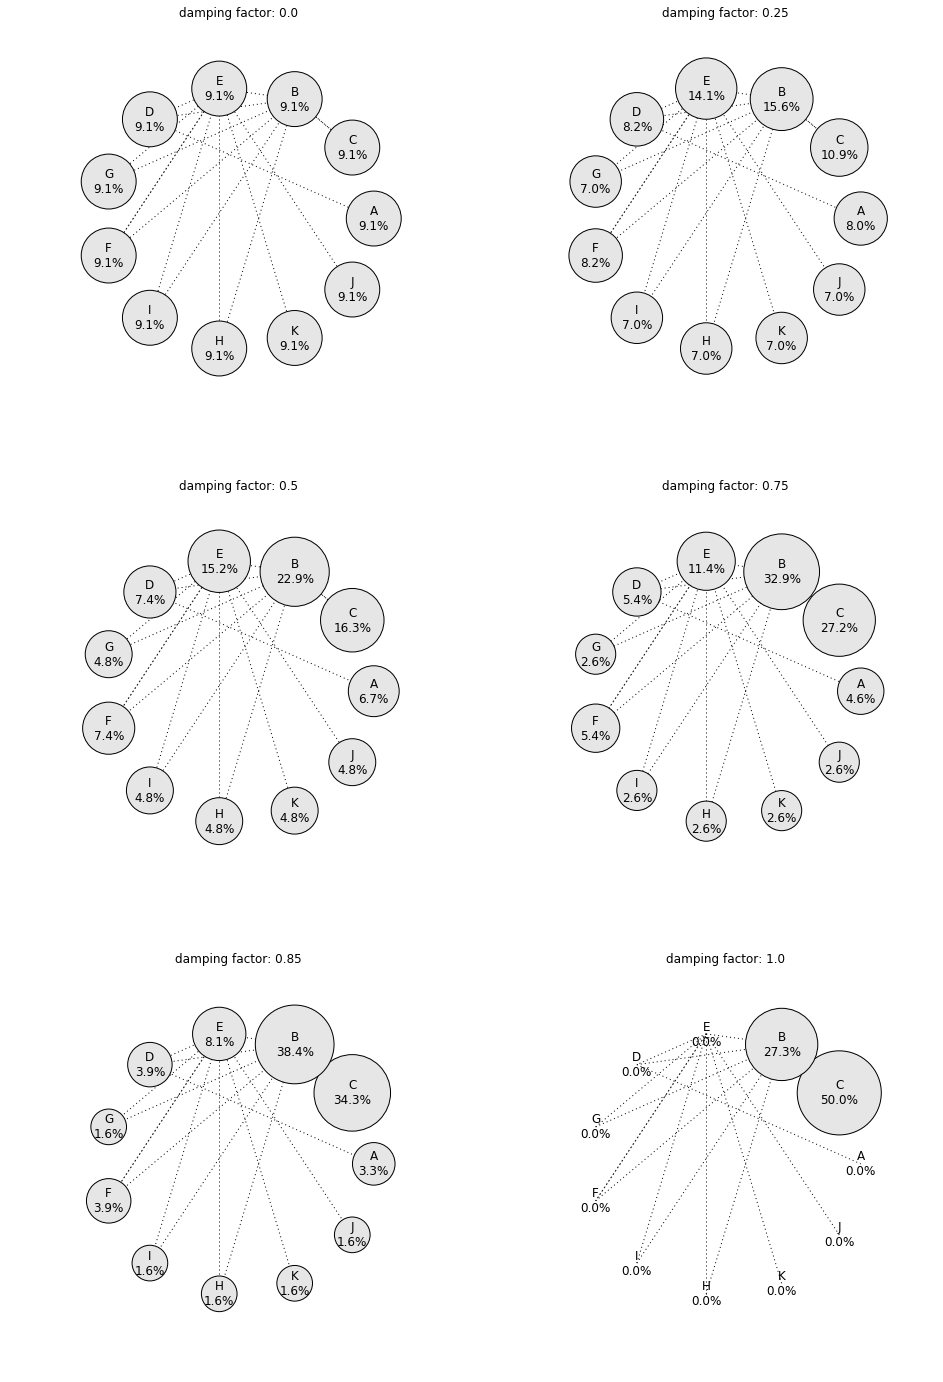

In [ ]:
import math

graph_id = 0

grid_cols = 2
grid_rows = math.ceil(len(damping_factors) / grid_cols)

fig = matplotlib.pyplot.figure(figsize = (16, 8 * grid_rows))

for damping_factor, page_ranks in sorted(graphs.iteritems()):
    graph_id += 1
    subplot = fig.add_subplot(grid_rows, grid_cols, graph_id)
    plot_page_rank(subplot, 'damping factor: ' + str(damping_factor), page_ranks)

# HW 9.3: Applying PageRank to the Wikipedia hyperlinks network

## Acquire Wikipedia hyperlinks network

We will need both the `-out` and the `-in` degree node files.

In [ ]:
wikipedia_out = get_s3_file('wikipedia', 'all-pages-indexed-out.txt')
wikipedia_in = get_s3_file('wikipedia', 'all-pages-indexed-in.txt')
wikipedia_in = get_s3_file('wikipedia', 'indices.txt')

Split the files so that Hadoop knows to create enough mapper tasks.

In [ ]:
split_for_hdfs(wikipedia_out)
split_for_hdfs(wikipedia_in)

It's easier to perform the page rank computation if we add all the dangling nodes to the graph.

In [ ]:
%time wikipedia_all = add_dangling_nodes_job('hadoop', wikipedia_out, wikipedia_in)

CPU times: user 10.2 s, sys: 1.52 s, total: 11.7 s
Wall time: 11min 5s


## Create job to sort by PageRank

In [ ]:
import heapq
import math
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import ReprProtocol
import sys

class PageRankTopNJob(MRJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    """
    Allow configuration of the N used for the top-N job.
    """
    def configure_options(self):
        super(PageRankTopNJob, self).configure_options()
        self.add_passthrough_option('--n', default=100, type='int')
        self.add_passthrough_option('--mapper-count', default=1, type='int')

    """
    Initialize our priority queue to an empty list.
    """
    def mapper_init(self):
        self.top_n = []

    """
    Buffer the top N results on the mapper side so that we can emit them during the final
    stage to reduce the amount of network traffic. Allows single reducer approach to work
    for larger networks like the Wikipedia graph.
    """
    def mapper(self, key, node_data):
        old_page_rank, older_page_rank, neighbors = node_data

        # Use log page rank in case we decide to switch over to Hadoop sort rather
        # than an in-memory sort for the reducer.

        log_page_rank = math.log(old_page_rank)
        heap_value = (log_page_rank, key, old_page_rank, older_page_rank, neighbors)

        if len(self.top_n) == self.options.n:
            heapq.heappushpop(self.top_n, heap_value)
        else:
            heapq.heappush(self.top_n, heap_value)

    """
    Emit each of the items to the None key so that we can perform a reducer-side sort.
    """
    def mapper_final(self):
        for item in self.top_n:
            yield None, item

    """
    Reducer which accumulates the top N and then emits them.
    """
    def reducer(self, _, all_items):
        top_n = []

        for item in all_items:
            if len(top_n) == self.options.n:
                heapq.heappushpop(top_n, item)
            else:
                heapq.heappush(top_n, item)

        for item in heapq.nlargest(self.options.n, top_n):
            key = item[1]
            node_data = item[2:]

            yield key, node_data

    """
    Set the mapper and reducer count options to make sure that MRJob creates enough
    mapper/reducer tasks.
    """
    def steps(self):
        step = MRStep(
            mapper_init = self.mapper_init, mapper = self.mapper,
            mapper_final = self.mapper_final, reducer = self.reducer,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count,
                'mapreduce.job.reduces': 1
            })

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = PageRankTopNJob()
    job.run()

Add a utility function to make it easy to call.

In [ ]:
def page_rank_top_n_job(runner_type, graph_file, n):
    output_folder = graph_file + '.top' + str(n)

    remove_folder(runner_type, output_folder)

    mrjob_graph_file = get_mrjob_path(runner_type, graph_file)
    mrjob_output_folder = get_mrjob_path(runner_type, output_folder)

    !python PageRankTopNJob.py \
        -r $runner_type \
        --strict-protocols \
        --no-bootstrap-mrjob \
        --no-output \
        --n $n \
        --mapper-count $mapper_count \
        --output-dir $mrjob_output_folder \
        $mrjob_graph_file \
        2> /dev/null

    output = pipe_cat_output(runner_type, output_folder)

    topn_graph = {}

    for line in output.split('\n'):
        key, result = line.split('\t', 1)

        name = eval(key)

        value = eval(result)
        page_rank = value[0]
        neighbors = value[2]

        topn_graph[name] = (page_rank, neighbors)

    return topn_graph

Also provide a utility function that can print it in a nice table.

In [ ]:
import pandas
pandas.set_option('display.precision', 4)
pandas.set_option('display.max_rows', 200)

"""
Prints the nodes in the page rank graph by joining on the given indices file. Essentially
this is a hash join but done outside of MapReduce.
"""
def get_page_rank_table(page_rank_graph):
    node_names = {}

    with open('input/wikipedia/indices.txt') as indices_file:
        for line in indices_file:
            node_name, node_id, rest = line.split('\t', 2)

            if node_id in page_rank_graph:
                node_names[node_id] = node_name

    page_rank_list = [
        (key, node_names[key], value[0])
            for key, value in page_rank_graph.iteritems()
    ]

    sorted_page_rank_list = sorted(page_rank_list, key = lambda x: x[2], reverse = True)

    return pandas.DataFrame(
        sorted_page_rank_list,
        columns = ['NodeId', 'NodeName', 'PageRank'])

## Prepare Wikipedia for PageRank

### Run PageRank for 5 iterations

First, we compute the number of dangling nodes.

In [ ]:
wikipedia_out_node_count = get_line_count('hadoop', wikipedia_out)
wikipedia_all_node_count = get_line_count('hadoop', wikipedia_all)
wikipedia_dangling_node_count = wikipedia_all_node_count - wikipedia_out_node_count

Then, we create a utility function which will run PageRank on the Wikipedia data set using the Hadoop runner.

In [ ]:
run_wikipedia_page_ranks = functools.partial(
    run_page_rank, 'hadoop', wikipedia_all, 'output/wikipedia',
    wikipedia_all_node_count, wikipedia_dangling_node_count, 0.85)

## Check PageRank after 5 iterations

> Run your PageRank implementation on the Wikipedia dataset for 5 iterations.

> [s3://ucb-mids-mls-networks/wikipedia/](http://s3-us-west-2.amazonaws.com/ucb-mids-mls-networks/wikipedia/)

> Display the top 100 ranked nodes with $d = 0.85$, corresponding to teleportation factor $(1-d) = 0.15$.

### Run PageRank for 5 iterations

In [ ]:
%time unsorted_wikipedia_page_ranks_05 = \
    run_wikipedia_page_ranks(5, 0, True, False, True)

2016-03-15 06:35:52.298975 Running PageRank iteration 3
2016-03-15 07:00:15.229310 Running convergence check for iteration 3
2016-03-15 07:04:51.012614 Running PageRank iteration 4
2016-03-15 07:27:51.682574 Running convergence check for iteration 4
2016-03-15 07:31:57.421949 Running PageRank iteration 5
2016-03-15 07:55:59.715481 Running convergence check for iteration 5
CPU times: user 1min 10s, sys: 11.8 s, total: 1min 22s
Wall time: 1h 25min 4s


### Check top 100 after 5 iterations

In [ ]:
%time top100_wikipedia_page_ranks_05 = \
    page_rank_top_n_job('hadoop', unsorted_wikipedia_page_ranks_05, 100)

Deleted /user/ubuntu/output/wikipedia/005.top100
CPU times: user 2.35 s, sys: 167 ms, total: 2.52 s
Wall time: 2min 37s


In [ ]:
wikipedia_df_05 = get_page_rank_table(top100_wikipedia_page_ranks_05)
wikipedia_df_05.to_csv('top100_wikipedia_page_ranks_05.csv')
wikipedia_df_05

,NodeId,NodeName,PageRank
0,13455888,United States,0.0015
1,1184351,Animal,0.0007
2,4695850,France,0.0006
3,5051368,Germany,0.0006
4,1384888,Arthropod,0.0005
5,7902219,List of sovereign states,0.0005
6,6113490,Insect,0.0005
7,2437837,Canada,0.0004
8,6076759,India,0.0004
9,13425865,United Kingdom,0.0004


## Check PageRank after 10 iterations

> Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes with $d = 0.85$, corresponding to teleportation factor $(1-d) = 0.15$.

### Run PageRank for 10 iterations

In [ ]:
%time unsorted_wikipedia_page_ranks_10 = \
    run_wikipedia_page_ranks(10, 0, True, False, True)

2016-03-15 08:19:25.593177 Running PageRank iteration 6
2016-03-15 08:37:10.350500 Running convergence check for iteration 6
2016-03-15 08:40:24.715343 Running PageRank iteration 7
2016-03-15 08:57:09.767643 Running convergence check for iteration 7
2016-03-15 09:00:46.333433 Running PageRank iteration 8
2016-03-15 09:18:32.381305 Running convergence check for iteration 8
2016-03-15 09:22:03.980942 Running PageRank iteration 9
2016-03-15 09:39:52.245350 Running convergence check for iteration 9
2016-03-15 09:43:28.774334 Running PageRank iteration 10
2016-03-15 10:00:14.413423 Running convergence check for iteration 10
CPU times: user 1min 28s, sys: 10.9 s, total: 1min 39s
Wall time: 1h 44min 32s


### Check top 100 after 5 iterations

In [ ]:
%time top100_wikipedia_page_ranks_10 = \
    page_rank_top_n_job('hadoop', unsorted_wikipedia_page_ranks_10, 100)

CPU times: user 2.18 s, sys: 395 ms, total: 2.58 s
Wall time: 2min 23s


In [ ]:
wikipedia_df_10 = get_page_rank_table(top100_wikipedia_page_ranks_10)
wikipedia_df_10.to_csv('top100_wikipedia_page_ranks_10.csv')
wikipedia_df_10

,NodeId,NodeName,PageRank
0,13455888,United States,0.0015
1,1184351,Animal,0.0007
2,4695850,France,0.0006
3,5051368,Germany,0.0006
4,1384888,Arthropod,0.0005
5,2437837,Canada,0.0004
6,6113490,Insect,0.0004
7,7902219,List of sovereign states,0.0004
8,13425865,United Kingdom,0.0004
9,6076759,India,0.0004


## Compare top 100 for different iterations

> Have the top 100 ranked pages changed? Comment on your findings.

### Overlap check

Find the set intersection to check for the number of nodes that overlap.

In [ ]:
top100_nodes_05 = set(top100_wikipedia_page_ranks_05.keys())
top100_nodes_10 = set(top100_wikipedia_page_ranks_10.keys())

intersection = top100_nodes_05 & top100_nodes_10
print 'intersection:', len(intersection), 'nodes'

intersection: 98 nodes


From the size of the intersection, we can see that the top 100 are consistently the same pages after the first 10 iterations (there is a 98% overlap) and that any position changes in the top 100 are probably switches between the pages.

### Distance check

We can also check the Levenshtein distance between the two rankings to see how much the rankings themselves have changed.

In [ ]:
# Borrowed under Creative Commons
# http://hetland.org/coding/python/levenshtein.py

def levenshtein(a,b):
    "Calculates the Levenshtein distance between a and b."
    n, m = len(a), len(b)
    if n > m:
        # Make sure n <= m, to use O(min(n,m)) space
        a,b = b,a
        n,m = m,n

    current = range(n+1)
    for i in range(1,m+1):
        previous, current = current, [i]+[0]*n
        for j in range(1,n+1):
            add, delete = previous[j]+1, current[j-1]+1
            change = previous[j-1]
            if a[j-1] != b[i-1]:
                change = change + 1
            current[j] = min(add, delete, change)

    return current[n]

levenshtein(wikipedia_df_05['NodeId'].tolist(), wikipedia_df_10['NodeId'].tolist())

48

The Levenshtein distance is 48, indicating that the similarity between the two rankings is only 52%. Therefore, while there is substantial overlap, the two are not as similar as the overlap suggests, suggesting that there is a lot of times where pages switch ranks.

### Plotted rank values

Finally, we can compare the plotted raw values for the page ranks.

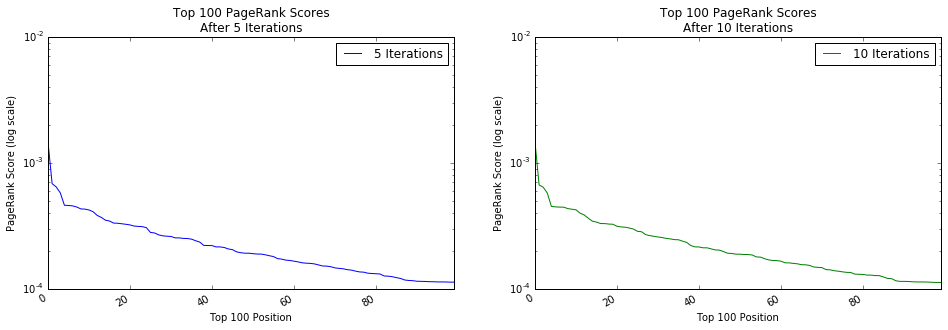

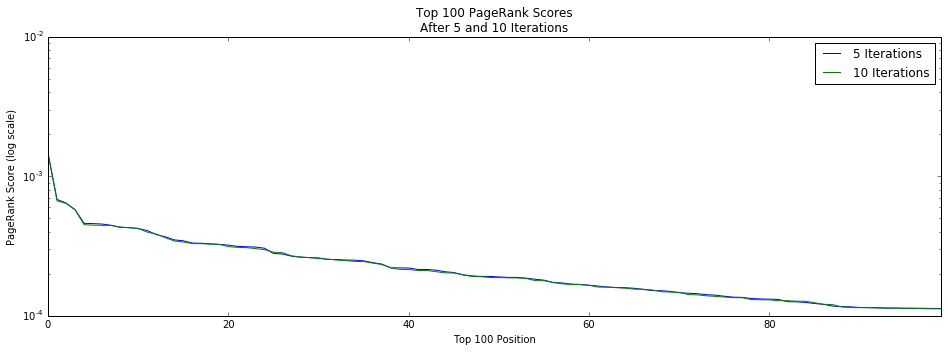

In [ ]:
import numpy

top100_comparison_df = pandas.concat(
    [wikipedia_df_05['PageRank'], wikipedia_df_10['PageRank']],
    axis = 1, keys = ['5 Iterations', '10 Iterations'])

# Plot both plots on separate plots.

subplots = top100_comparison_df.plot(
    figsize = (16, 5), layout = (1, 2),
    logy = True, kind = 'line', subplots = True)

subplots[0][0].set_title('Top 100 PageRank Scores\nAfter 5 Iterations')
subplots[0][0].set_xlabel('Top 100 Position')
subplots[0][0].set_ylabel('PageRank Score (log scale)')

subplots[0][1].set_title('Top 100 PageRank Scores\nAfter 10 Iterations')
subplots[0][1].set_xlabel('Top 100 Position')
subplots[0][1].set_ylabel('PageRank Score (log scale)')

# Plot both plots on the same plot, but with log scale to make small differences
# more visible.

subplot = top100_comparison_df.plot(
    figsize = (16, 5),
    logy = True, kind = 'line')

subplot.set_title('Top 100 PageRank Scores\nAfter 5 and 10 Iterations')
subplot.set_xlabel('Top 100 Position')
subplot.set_ylabel('PageRank Score (log scale)');

This shows that if we look at the log of the page rank values independent of the pages, the two line plots very nearly overlap with each other.

## Plot networkx graph for top 100 ranked pages

> Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.

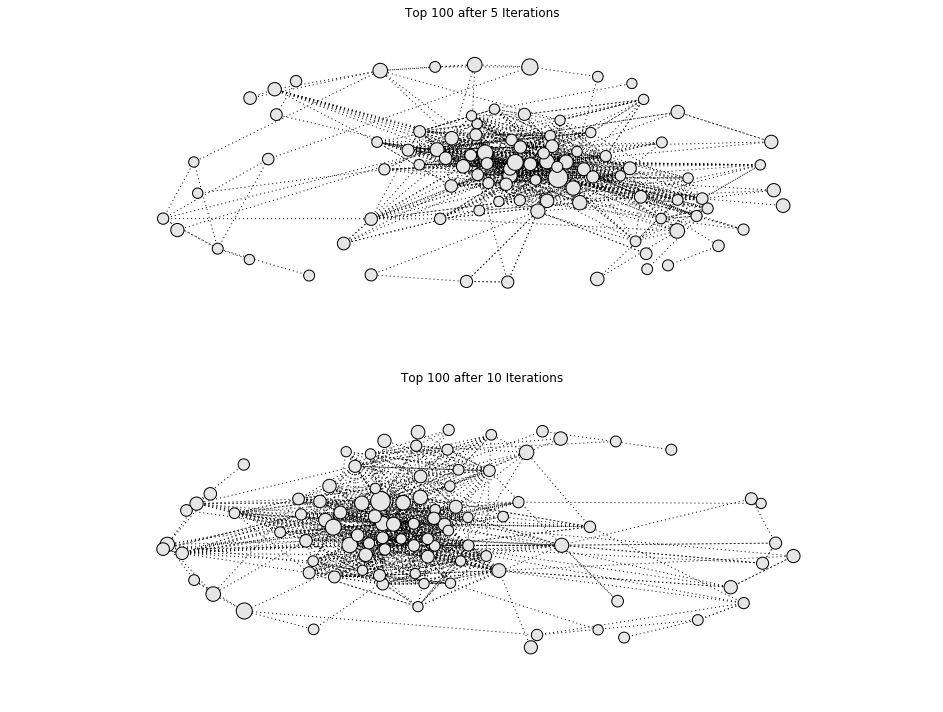

In [ ]:
import math

fig = matplotlib.pyplot.figure(figsize = (16, 12))

subplot = fig.add_subplot(2, 1, 1)
plot_page_rank(subplot, 'Top 100 after 5 Iterations', top100_wikipedia_page_ranks_05)

subplot = fig.add_subplot(2, 1, 2)
plot_page_rank(subplot, 'Top 100 after 10 Iterations', top100_wikipedia_page_ranks_10)

# HW 9.4: Topic-specific PageRank implementation using MRJob

## Create Topic-specific PageRank MRJob

> Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:

> http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

> Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

> >	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

> and must be adhered to for convergence to be guaranteed.

## Acquire Topic-specific PageRank test data

> Run topic specific PageRank on the following randomly generated network of 100 nodes:

> * [s3://ucb-mids-mls-networks/randNet.txt](http://s3-us-west-2.amazonaws.com/ucb-mids-mls-networks/randNet.txt) (S3)
> * https://www.dropbox.com/sh/2c0k5adwz36lkcw/AACEBW8MKuzl2L-tH_FmuG9ba/randNet.txt (Dropbox)

> which are organized into ten topics, as described in the file:

> * [s3://ucb-mids-mls-networks/randNet_topics.txt](http://s3-us-west-2.amazonaws.com/ucb-mids-mls-networks/randNet_topics.txt) (S3)
> * https://www.dropbox.com/sh/2c0k5adwz36lkcw/AACTOoH1Oi03JxjOaW-Cy4N8a/randNet_topics.txt (Dropbox)

> Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes
and their topics for each of the 11 versions, and comment on your result.
Assume a teleportation factor of 0.15 in all your analyses.

In [ ]:
randnet_out = get_dropbox_file(
    '2c0k5adwz36lkcw/AACEBW8MKuzl2L-tH_FmuG9ba', 'randNet', 'randNet.txt')
randnet_topics = get_dropbox_file(
    '2c0k5adwz36lkcw/AACTOoH1Oi03JxjOaW-Cy4N8a', 'randNet', 'randNet_topics.txt')

## Run Topic-specific PageRank on test data

> One final and important comment here:  please consider the
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.

> This is not a small task, especially as it it must be performed
separately for each of the (10) topics.

> So, instead of using this method for irreducibility,
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.
Then for your code, please use the alternative,
non-uniform damping vector:

> vji = beta*(1/|Tj|); if node i lies in topic Tj

> vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj

> for beta in (0,1) close to 1.

> With this approach, you will not have to delete any nodes.
If beta > 0.5, PageRank is topic-sensitive,
and if beta < 0.5, the PageRank is anti-topic-sensitive.
For any value of beta irreducibility should hold,
so please try beta=0.99, and perhaps some other values locally,
on the smaller networks.

# HW 9.5: Applying topic-specific PageRank to Wikipedia

> Here you will apply your topic-specific PageRank implementation to Wikipedia,
defining topics (very arbitrarily) for each page by the length (number of characters) of the name of the article mod 10,
so that there are 10 topics. Once again, print out the top ten ranking nodes
and their topics for each of the 11 versions, and comment on your result.
Assume a teleportation factor of 0.15 in all your analyses.


# HW 9.6: TextRank (OPTIONAL)

> What is TextRank. Describe the main steps in the algorithm. Why does TextRank work?
Implement TextRank in MrJob for keyword phrases (not just unigrams) extraction using co-occurrence based similarity measure with with sizes of N = 2 and 3. And evaluate your code using the following example using precision, recall, and FBeta (Beta=1):

> ```
"Compatibility of systems of linear constraints over the set of natural numbers
Criteria of compatibility of a system of linear Diophantine equations, strict
inequations, and nonstrict inequations are considered. Upper bounds for
components of a minimal set of solutions and algorithms of construction of
minimal generating sets of solutions for all types of systems are given.
These criteria and the corresponding algorithms for constructing a minimal
supporting set of solutions can be used in solving all the considered types of
systems and systems of mixed types."
```

> The extracted keywords should in the following set:

> ```
linear constraints, linear diophantine equations, natural numbers, non-strict inequations, strict inequations, upper bounds
```